In [1]:
import requests
from serpapi import GoogleSearch
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
from groq import Groq

load_dotenv('../.env')

True

## Set up sentiment model and prompt

In [27]:
client = Groq(api_key = os.getenv('GROQ_API_KEY'))

prompt = \
"""Does this article indicate that the probability of a trade war is higher, lower, or unchanged?
Please respond with either 'higher', 'lower', or 'unchanged'\n\n{article}"""

def get_trade_war_sentiment(client, transcript):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that determines the sentiment of text."
            },
            {
                "role": "user",
                "content": prompt.format(article=transcript)
            }
        ],
        
        # try this again when my use limit resets
        model="llama-3.3-70b-versatile",

        # this one does thinking which uses all the terms
        # maybe instruct it to format the result?
        # model="deepseek-r1-distill-llama-70b", 
    )

    return chat_completion.choices[0].message.content


## Do Google search

In [3]:
# reference:  https://serpapi.com/search-api

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Start date
start_date = datetime(2020, 1, 1)

# Number of 6-month intervals to generate
num_intervals = 11  # You can change this as needed

# Generate and print the dates
cd_mins = [start_date + relativedelta(months=6*i) for i in range(num_intervals)]
cd_maxs = [start_date + relativedelta(months=+6*(i+1), days=-1) for i in range(num_intervals)]
for cd_min, cd_max in zip(cd_mins, cd_maxs):
    print(cd_min.strftime("%m/%d/%Y"), cd_max.strftime("%m/%d/%Y"))

01/01/2020 06/30/2020
07/01/2020 12/31/2020
01/01/2021 06/30/2021
07/01/2021 12/31/2021
01/01/2022 06/30/2022
07/01/2022 12/31/2022
01/01/2023 06/30/2023
07/01/2023 12/31/2023
01/01/2024 06/30/2024
07/01/2024 12/31/2024
01/01/2025 06/30/2025


In [4]:
all_search_res = {}
for cd_min, cd_max in zip(cd_mins, cd_maxs):
    print(f'searching {cd_min.strftime("%m/%d/%Y")} - {cd_max.strftime("%m/%d/%Y")}...')
    params = {
        'q': "US tariff news, analysis, and predictions",
        'engine': 'google',
        'api_key': os.getenv('SERPAPI_API_KEY'),
        'tbs': f'cdr:1,cd_min:{cd_min.strftime("%m/%d/%Y")},cd_max:{cd_max.strftime("%m/%d/%Y")}',
        'num': 40
    }
        
    search = GoogleSearch(params)
    results = search.get_dict()
    search_res = [result.get('link') for result in results["organic_results"]]

    # limiting search_res for debugging
    search_res = search_res[0:20]

    all_search_res[cd_min] = search_res

searching 01/01/2020 - 06/30/2020...
searching 07/01/2020 - 12/31/2020...
searching 01/01/2021 - 06/30/2021...
searching 07/01/2021 - 12/31/2021...
searching 01/01/2022 - 06/30/2022...
searching 07/01/2022 - 12/31/2022...
searching 01/01/2023 - 06/30/2023...
searching 07/01/2023 - 12/31/2023...
searching 01/01/2024 - 06/30/2024...
searching 07/01/2024 - 12/31/2024...
searching 01/01/2025 - 06/30/2025...


In [5]:
len(all_search_res[cd_min])

20

## Follow each link, and pull out the text

In [6]:
%%time
## TODO handle video - either skip it or extract the text from the audio
## TODO handle pages that are taking too long to respond

def get_text(url):
    try:
        print(f'downloading {url}...')
        response = requests.get(url)
        html = response.text
        text = BeautifulSoup(html, features="html.parser").get_text().strip()
    except:
        print(f'****could not download {url}')
        text = 'could not download'
        
    return text

all_documents = {}
for k, urls in all_search_res.items():
    print(f'processing {k}...')
    all_documents[k] = [get_text(url) for url in urls]


processing 2020-01-01 00:00:00...
downloading https://www.freightwaves.com/news/tag/trade-tariffs?__hstc=9610282.0787aea508c4a7020a775d49cd9c8e4b.1559606400152.1559606400153.1559606400154.1&__hssc=9610282.1.1559606400155&__hsfp=548636614...
downloading https://foreignpolicy.com/projects/trade-war-tariffs-economy-trump-china/...
downloading https://macenews.com/category/economy/government/white-house/trump/...
downloading https://www.americanactionforum.org/series/eye-on-trade/...
downloading https://www.newsnow.com/us/Business/World+Economy/International+Trade...
downloading https://www.forbes.com/sites/stuartanderson/2020/01/21/trump-tariff-aid-to-farmers-cost-more-than-us-nuclear-forces/...
downloading https://www.wto.org/english/res_e/reser_e/ersd202004_e.htm...
downloading https://www.ig.com/en/news-and-trade-ideas...
downloading https://www.reuters.com/article/business/trumps-tariffs-cost-us-companies-46-billion-to-date-data-shows-idUSKBN1Z8221/...
downloading https://www.cnbc.com

## Determine sentiment of document

In [33]:
%%time

doc_len_limit = 8000

all_sentiment = {}
for i, (k, docs) in enumerate(all_documents.items()):
    
    ## ran out of tokens after 8. putting this here to finish
    # if (i+1) < 9:
    #    continue
    
    
    print(f'{i+1}/{len(all_documents)}: generating sentiment for {k.strftime("%m/%d/%Y")}...')
    all_sentiment[k] = [get_trade_war_sentiment(client, doc[:doc_len_limit]) for doc in docs]

9/11: generating sentiment for 01/01/2024...
10/11: generating sentiment for 07/01/2024...
11/11: generating sentiment for 01/01/2025...
CPU times: user 406 ms, sys: 75.9 ms, total: 482 ms
Wall time: 1min 53s


In [34]:
len(all_sentiment)

3

In [29]:
all_sentiment[cd_mins[0]]

['unchanged',
 'unchanged',
 'unchanged',
 'Lower',
 'Higher',
 "The text provided does not mention a trade war. Therefore, I must conclude that the probability of a trade war is 'unchanged'.",
 'Lower',
 'Lower',
 'Unable to analyze the article as the content is not provided. To determine if the probability of a trade war is higher, lower, or unchanged, the actual text of the article is needed.',
 'unchanged',
 'unchanged',
 "I'm happy to help, but I don't see an article provided. The text only includes a link to the New York Times website. Could you please copy and paste the text of the article, and I'll do my best to determine the sentiment regarding the probability of a trade war?",
 'Higher',
 'Unable to analyze the article as the text provided does not contain any information. Please provide the actual article text to determine the sentiment regarding the probability of a trade war.',
 'Lower',
 'unchanged',
 'unchanged',
 'higher',
 'unchanged',
 'Lower']

## Visualize data

In [21]:
import matplotlib.pyplot as plt
import random
#all_sentiment_test = {cd_min: [random.choice(['higher', 'lower', 'unchanged']) for _ in range(10)] for cd_min in cd_mins}
#all_sentiment_test

In [22]:
def count_sent(ls, val):
    #print(f'{ls=}, {val=}')
    return sum(val in item.lower() for item in ls) / len(ls)

count_sent(['lower',
  'unchanged',
  'lower',
  'higher',
  'unchanged',
  'higher',
  'lower',
  'higher',
  'lower',
  'lower'],'higher')

0.3

In [43]:



nums = {}

#for date, sentiments in all_sentiment.items():
## hacking in the loaded sentiments
for date, sentiments in v_final.items():
    nums[date] = [count_sent(sentiments,val) for val in ['higher', 'unchanged', 'lower']]
nums

{datetime.datetime(2020, 1, 1, 0, 0): [0.2, 0.5, 0.3],
 datetime.datetime(2020, 7, 1, 0, 0): [0.3, 0.4, 0.3],
 datetime.datetime(2021, 1, 1, 0, 0): [0.1, 0.45, 0.3],
 datetime.datetime(2021, 7, 1, 0, 0): [0.25, 0.5, 0.35],
 datetime.datetime(2022, 1, 1, 0, 0): [0.25, 0.7, 0.25],
 datetime.datetime(2022, 7, 1, 0, 0): [0.3, 0.5, 0.3],
 datetime.datetime(2023, 1, 1, 0, 0): [0.15, 0.75, 0.3],
 datetime.datetime(2023, 7, 1, 0, 0): [0.2, 0.7, 0.15],
 datetime.datetime(2024, 1, 1, 0, 0): [0.6, 0.35, 0.05],
 datetime.datetime(2024, 7, 1, 0, 0): [0.6, 0.3, 0.05],
 datetime.datetime(2025, 1, 1, 0, 0): [0.5, 0.3, 0.3]}

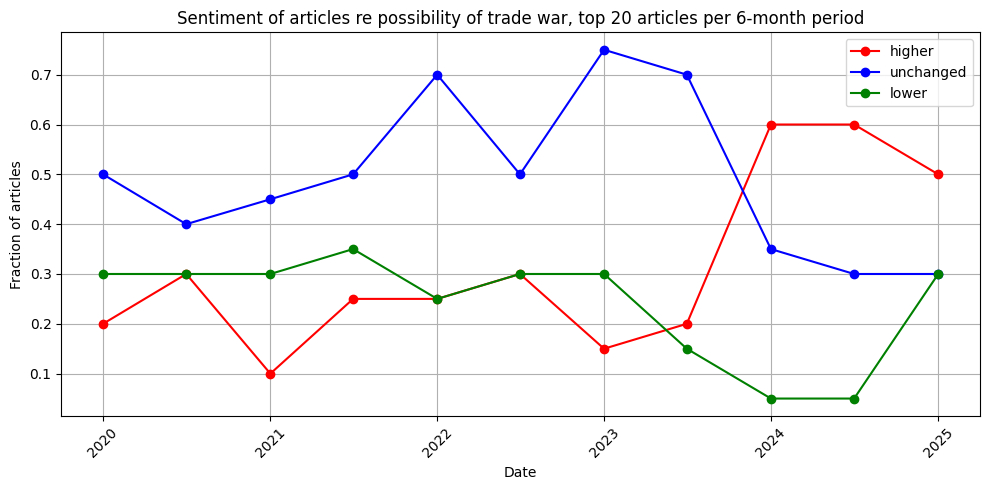

In [46]:
higher = {k:v[0] for k,v in nums.items()}
unchanged = {k:v[1] for k,v in nums.items()}
lower = {k:v[2] for k,v in nums.items()}
dates = higher.keys()

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(dates, higher.values(), marker='o', linestyle='-', color='red', label='higher')
plt.plot(dates, unchanged.values(), marker='o', linestyle='-', color='blue', label='unchanged')
plt.plot(dates, lower.values(), marker='o', linestyle='-', color='green', label='lower')

# Format the x-axis to show dates nicely
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Fraction of articles')
plt.title('Sentiment of articles re possibility of trade war, top 20 articles per 6-month period')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [35]:
## Pickle some stuff for later work
import pickle

# Pickle the dictionary to a file
with open('all_sentiment_40_versatile-9to11of11.pkl', 'wb') as f:
    pickle.dump(all_sentiment, f)



In [26]:
with open('all_search_res_40.pkl', 'wb') as f:
    pickle.dump(all_search_res, f)
with open('all_documents_40.pkl', 'wb') as f:
    pickle.dump(all_documents, f)
all_documents

In [39]:
## Load pickles into single sentiment var
with open('sentiment_versatile_40/all_sentiment_40_versatile-9to11of11.pkl', 'rb') as f:
    v = pickle.load(f)
with open('sentiment_versatile_40/all_sentiment_40_versatile-8of11.pkl', 'rb') as f:
    v_final = pickle.load(f)
v_final = v_final | v
len(v_final)

In [45]:
[len(d) for d in v_final.values()]

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]